In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [11]:
def system_step(prev_y, prev2_y, prev_x, prev2_x, prev_z):
    new_y = prev_y + 0.01*prev2_y + 8.0*prev_x - 0.3*prev2_x + 0.1*prev_z
    new_z = prev_z + 2.0*prev_x + 0.11
    return new_y, new_z

def optimal_x(desired_y, prev_y, prev2_y, prev2_x, prev_z):
    numerator = desired_y - prev_y - 0.01*prev2_y + 0.3*prev2_x - 0.1*prev_z
    return numerator / 8.0

In [12]:
def generate_data(n_series=600, T=128, y_star_range=(-10, 10), noise_std=0.02):
    features, targets = [], []
    for _ in range(n_series):
        prev2_y = np.random.uniform(-2, 2)
        prev_y = np.random.uniform(-2, 2)
        prev2_x = np.random.uniform(-0.5, 0.5)
        prev_z = np.random.uniform(-1, 1)
        desired_y = np.random.uniform(*y_star_range)
        for _ in range(T):
            x_opt = optimal_x(desired_y, prev_y, prev2_y, prev2_x, prev_z)
            x_noisy = x_opt + np.random.normal(0.0, noise_std)
            
            
            features.append([prev_y, prev2_y, prev2_x, prev_z, desired_y])
            targets.append(x_noisy)
            
            
            new_y, new_z = system_step(prev_y, prev2_y, x_opt, prev2_x, prev_z)
            prev2_y, prev_y = prev_y, new_y
            prev2_x, prev_z = x_opt, new_z
            
            
            if np.random.rand() < 0.1:
                desired_y = np.random.uniform(*y_star_range)
    return np.array(features, dtype=np.float32), np.array(targets, dtype=np.float32)

In [13]:
def build_model(input_dim=5, hidden=64):
    model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(hidden, activation='relu'),
    layers.Dense(hidden, activation='relu'),
    layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
    return model

In [14]:
def simulate_demo(model, T=400, switch_i=200, y1=5.0, y2=7.0, clip_x=5.0):
    prev2_y, prev_y, prev2_x, prev_z = 0.0, 0.0, 0.0, 0.0
    ys, xs, zs, desired_values = [], [], [], []
    for i in range(T):
        desired_y = y1 if i < switch_i else y2
        feat = np.array([[prev_y, prev2_y, prev2_x, prev_z, desired_y]], dtype=np.float32)
        x_pred = float(model.predict(feat, verbose=0)[0,0])
        x_pred = float(np.clip(x_pred, -clip_x, clip_x))
        
        new_y, new_z = system_step(prev_y, prev2_y, x_pred, prev2_x, prev_z)
         
        ys.append(new_y)
        xs.append(x_pred)
        zs.append(new_z)
        desired_values.append(desired_y)
        
        
        prev2_y, prev_y = prev_y, new_y
        prev2_x, prev_z = x_pred, new_z

    
    ys, xs, zs, desired_values = map(np.array, [ys, xs, zs, desired_values])
    mae = np.mean(np.abs(ys - desired_values))
    print(f"Demo MAE = {mae:.4f}")
    fig, axs = plt.subplots(3,1,figsize=(10,8),sharex=True)
    axs[0].plot(ys,label='y'); axs[0].plot(desired_values,'--',label='y*'); axs[0].legend(); axs[0].set_ylabel('y')
    axs[1].plot(xs); axs[1].set_ylabel('x')
    axs[2].plot(zs); axs[2].set_ylabel('z'); axs[2].set_xlabel('timestep')
    for ax in axs: ax.axvline(switch_i,color='k',linestyle=':',alpha=0.6)
    plt.show()

In [15]:

X, y = generate_data()
print("Dataset shape:", X.shape, y.shape)

Dataset shape: (76800, 5) (76800,)


In [19]:
model = build_model()
cb = [callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
history = model.fit(X, y, validation_split=0.1, epochs=50, batch_size=2048, callbacks=cb)

Epoch 1/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0475 - mae: 0.1085 - val_loss: 0.0063 - val_mae: 0.0469
Epoch 2/50
34/34 [==============================] - 0s 5ms/step - loss: 0.0029 - mae: 0.0334 - val_loss: 0.0017 - val_mae: 0.0267
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0013 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0225
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 9.2343e-04 - mae: 0.0213 - val_loss: 8.8032e-04 - val_mae: 0.0209
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 7.7199e-04 - mae: 0.0202 - val_loss: 7.7092e-04 - val_mae: 0.0202
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 6.9595e-04 - mae: 0.0195 - val_loss: 6.9616e-04 - val_mae: 0.0194
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 6.5372e-04 - mae: 0.0191 - val_loss: 6.6373e-04 - val_mae: 0.0192
Epoch 8/50
34/34 [==============================] - 0s 3ms

In [20]:
model.save("policy_model.h5")
loaded_model = models.load_model("policy_model.h5")

Demo MAE = 0.0242


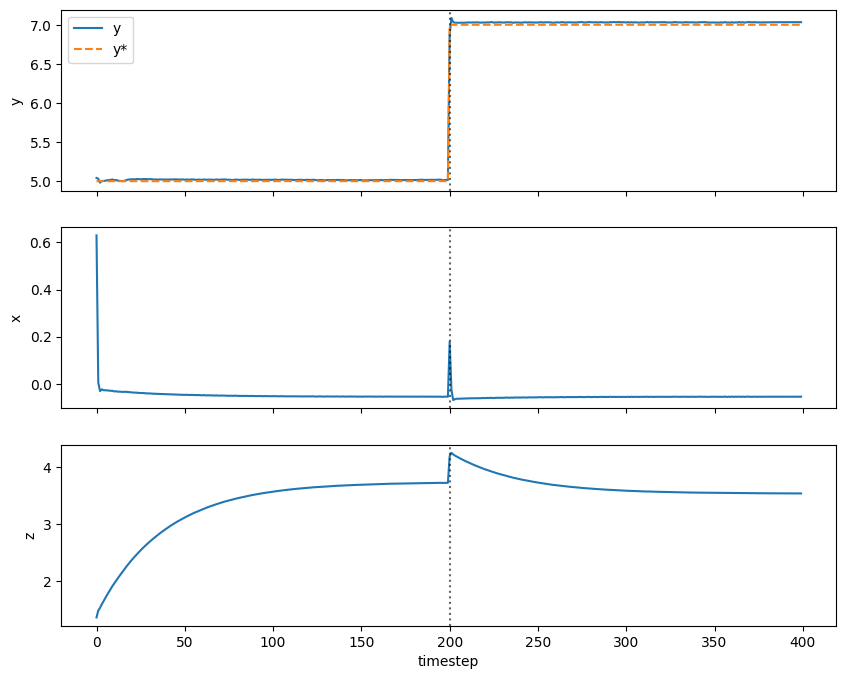

In [21]:
simulate_demo(loaded_model)